# Project Prediction Regressor: Analisis dan Prediksi Average Daily Rate (ADR) untuk Meningkatkan Pendapatan Hotel

In [ ]:
!pip install scipy==1.11.4
!pip install scikit-plot
!pip install dalex
!pip install shap
!pip install lime
!pip install optuna
!pip install scikit-learn==1.2.0 imbalanced-learn==0.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 723.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.1-py3-none-any.whl size=1042797 sha256=82cfc921ae2139b97c9130d059fc6f1eff36b15bf1197466cdab6ccb8a8acf28
  Stored in directory: /root/.cache/pip/wheels/50/24/3e/5a88876cfa3bd019ba82ec57c228eae1a37f479c0f8353e5cb
Successfully built dalex
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b0ea1036ae40ec283bc9a4f8f393dd57775c86b26370d5c9f3715c6af4b95eb4
  Stored in dir

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
import dalex as dx
import shap
import optuna
from lime.lime_tabular import LimeTabularExplainer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
import scikitplot as skplt

In [ ]:
pd.set_option('display.max_columns', None)

## Bussiness Understanding

### Goals

  <table>
      <tr>
          <td>Introduction</td>
          <td>Average Daily Rate (ADR) adalah metrik yang digunakan dalam industri perhotelan untuk mengukur pendapatan rata-rata per kamar yang ditempati selama periode tertentu.<br> Dengan memahami ADR dapat membantu operasional hotel dalam strategi penetapan harga dan juga dapat mengidentifikasi tren.</td>
      </tr>
      <tr>
          <td>Goals</td>
          <td>1. Memahami tren ADR<br>
              2. Memperkirakan tren ADR
          </td>
      </tr>
      <tr>
          <td>Business Objective</td>
          <td>Memanfaatkan pola ADR untuk merancang strategi pemasaran yang lebih baik.</td>
      </tr>
  </table>

### Feature Explanation

  <table>
            <tr>
                <th>Variable Name</th>
                <th>Description</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>hotel</td>
                <td>hotel name</td>
            </tr>
            <tr>
                <td>is_canceled</td>
                <td>Whether the booking was canceled or not (Binary)</td>
            </tr>
            <tr>
                <td>lead_time</td>
                <td>Number of days between booking date and arrival date (Numeric)</td>
            </tr>
            <tr>
                <td>arrival_date_year</td>
                <td>The year of the arrival date (Numeric)</td>
            </tr>
            <tr>
                <td>arrival_date_month</td>
                <td>The month of the arrival date (Categorical)</td>
            </tr>
            <tr>
                <td>arrival_date_week_number</td>
                <td>The week number of the arrival date (Numeric)</td>
            </tr>
            <tr>
                <td>arrival_date_day_of_month</td>
                <td>The day of the month of the arrival date (Numeric)</td>
            </tr>
            <tr>
                <td>stays_in_weekend_nights</td>
                <td>Number of weekend nights stayed or booked to stay at the hotel (Numeric)</td>
            </tr>
            <tr>
                <td>stays_in_week_nights</td>
                <td>Number of week nights stayed or booked to stay at the hotel (Numeric)</td>
            </tr>
            <tr>
                <td>adults</td>
                <td>Number of adults</td>
            </tr>
            <tr>
                <td>children</td>
                <td>Number of children</td>
            </tr>
            <tr>
                <td>babies</td>
                <td>Number of infants</td>
            </tr>
            <tr>
                <td>meal</td>
                <td>Type(s) of food option(s) included in booking package (Categorical)</td>
            </tr>
            <tr>
                <td>country</td>
                <td>Guest's country of origin</td>
            </tr>
            <tr>
                <td>market_segment</td>
                <td>Market segment classification</td>
            </tr>
            <tr>
                <td>distribution_channel</td>
                <td>Booking distribution channel</td>
            </tr>
            <tr>
                <td>is_repeated_guest</td>
                <td>Whether the guest is a repeated visitor (Binary)</td>
            </tr>
            <tr>
                <td>previous_cancellations</td>
                <td>Number of previous bookings canceled by the guest</td>
            </tr>
            <tr>
                <td>previous_bookings_not_canceled</td>
                <td>Number of previous bookings not canceled by the guest</td>
            </tr>
            <tr>
                <td>reserved_room_type</td>
                <td>Type of room originally reserved</td>
            </tr>
            <tr>
                <td>assigned_room_type</td>
                <td>Type of room assigned at check-in</td>
            </tr>
            <tr>
                <td>booking_changes</td>
                <td>Number of changes made to the booking</td>
            </tr>
            <tr>
                <td>deposit_type</td>
                <td>Type of deposit made for the booking (Categorical)</td>
            </tr>
            <tr>
                <td>agent</td>
                <td>Booking agent identifier</td>
            </tr>
            <tr>
                <td>company</td>
                <td>Company identifier involved in the booking</td>
            </tr>
            <tr>
                <td>days_in_waiting_list</td>
                <td>Number of days the booking was on the waiting list</td>
            </tr>
            <tr>
                <td>customer_type</td>
                <td>Type of customer (e.g., transient, group)</td>
            </tr>
            <tr>
                <td>adr</td>
                <td>Average daily rate per room (Numeric)</td>
            </tr>
        </tbody>
  </table>

## Data Understanding

In [ ]:
hotel = pd.read_csv('train.csv')
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0.0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314.0,NaN,0,Transient,38.40,0,0,Check-Out,2019-01-14,1
1,"Greensboro Courtyard Greensboro, NC",1,524,2018,December,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,NaN,0,Transient,62.80,0,0,Canceled,2017-10-21,2
2,"The Westin Peachtree Plaza, Atlanta Atlanta, GA",1,175,2019,May,20,19,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,12.0,NaN,0,Transient,110.00,0,0,Canceled,2018-11-25,3
3,Courtyard by Marriott Aberdeen Airport Aberdee...,0,0,2018,October,43,17,1,0,1,0.0,0,BB,NaN,Corporate,Corporate,0,0,0,A,A,0,No Deposit,NaN,200.0,0,Transient,45.00,0,0,Check-Out,2018-10-18,4
4,"W New York – Union Square New York, NY",1,33,2017,September,39,26,2,3,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,16.0,NaN,0,Transient,57.92,0,1,Canceled,2017-08-24,5


In [ ]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83293 entries, 0 to 83292
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83293 non-null  object 
 1   is_canceled                     83293 non-null  int64  
 2   lead_time                       83293 non-null  int64  
 3   arrival_date_year               83293 non-null  int64  
 4   arrival_date_month              83293 non-null  object 
 5   arrival_date_week_number        83293 non-null  int64  
 6   arrival_date_day_of_month       83293 non-null  int64  
 7   stays_in_weekend_nights         83293 non-null  int64  
 8   stays_in_week_nights            83293 non-null  int64  
 9   adults                          83293 non-null  int64  
 10  children                        83290 non-null  float64
 11  babies                          83293 non-null  int64  
 12  meal                            

In [ ]:
hotel.shape

(83293, 33)

Terdapat 83.293 baris dengan 33 feature. 12 feature kategorik, 20 feature numerik dan 1 target (adr)

## Data Cleaning

In [ ]:
hotel.duplicated().sum()

0

In [ ]:
hotel.isna().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


## Data Manipulation

In [ ]:
hotel = hotel.drop(['bookingID'], axis=1)

### Manipulation Feature is_canceled

In [ ]:
hotel['is_canceled'] = hotel['is_canceled'].map({0:'No', 1:'Yes'})

### Manipulation Feature reservation_status_date

In [ ]:
hotel['reservation_status_date'] = pd.to_datetime(hotel['reservation_status_date'])

In [ ]:
hotel['reservation_year'] = hotel['reservation_status_date'].dt.year
hotel['reservation_month'] = hotel['reservation_status_date'].dt.month
hotel['reservation_day'] = hotel['reservation_status_date'].dt.day
hotel['reservation_dayofweek'] = hotel['reservation_status_date'].dt.dayofweek

In [ ]:
hotel = hotel.drop('reservation_status_date', axis=1)

In [ ]:
hotel = hotel.drop_duplicates()

In [ ]:
hotel = hotel.dropna(subset=['country', 'children'])

### Manipulation Agent and Company Feature

In [ ]:
hotel['agent_available'] = hotel['agent'].apply(lambda x: 'Yes' if pd.notna(x) else 'No')

In [ ]:
hotel['company_available'] = hotel['company'].apply(lambda x: 'Yes' if pd.notna(x) else 'No')

In [ ]:
hotel = hotel.drop(['agent', 'company'], axis=1)

In [ ]:
hotel_real = hotel.copy()

### Encoding data

#### Change Data Type Reservation Date

In [ ]:
hotel['reservation_year'] = hotel['reservation_year'].astype('int64')
hotel['reservation_month'] = hotel['reservation_month'].astype('int64')
hotel['reservation_day'] = hotel['reservation_day'].astype('int64')
hotel['reservation_dayofweek'] = hotel['reservation_dayofweek'].astype('int64')

In [ ]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_year,reservation_month,reservation_day,reservation_dayofweek,agent_available,company_available
0,"Crystal Cove, Barbados Barbados",No,8,2019,January,2,10,0,4,2,...,38.40,0,0,Check-Out,2019,1,14,0,Yes,No
1,"Greensboro Courtyard Greensboro, NC",Yes,524,2018,December,51,15,0,2,2,...,62.80,0,0,Canceled,2017,10,21,5,Yes,No
2,"The Westin Peachtree Plaza, Atlanta Atlanta, GA",Yes,175,2019,May,20,19,1,2,2,...,110.00,0,0,Canceled,2018,11,25,6,Yes,No
4,"W New York – Union Square New York, NY",Yes,33,2017,September,39,26,2,3,2,...,57.92,0,1,Canceled,2017,8,24,3,Yes,No
5,"Hotel Maria Cristina, San Sebastian San Sebast...",Yes,395,2018,March,13,21,1,2,2,...,62.80,0,0,Canceled,2017,8,10,3,Yes,No


In [ ]:
numeric = [] # Mengambil nama kolom numerik data setelah displit
categoric = []# Mengambil nama kolom kategorik data setelah displit
for col in hotel.columns:
  if hotel[col].dtypes in ['int64', 'float']:
    numeric.append(col)
  elif hotel[col].dtypes == 'object':
    categoric.append(col)
print('Kolom numerik', numeric)
print('Kolom kategorik', categoric)

Kolom numerik ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_year', 'reservation_month', 'reservation_day', 'reservation_dayofweek']
Kolom kategorik ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'agent_available', 'company_available']


In [ ]:
fill_category = [] #Mengecek nilai unik per feature
for i in hotel.columns:
  if hotel[i].dtypes == 'object':
    fill_category.append({'Columns': i, 'Category':hotel[i].unique()})
fill_category

[{'Columns': 'hotel',
  'Category': array(['Crystal Cove, Barbados Barbados',
         'Greensboro Courtyard Greensboro, NC',
         'The Westin Peachtree Plaza, Atlanta Atlanta, GA ',
         'W New York – Union Square New York, NY',
         'Hotel Maria Cristina, San Sebastian San Sebastian, Spain',
         'W New York – Times Square New York, NY',
         'The Ritz-Carlton, Tokyo Tokyo, Japan',
         'Marriott Puerto Vallarta Resort & Spa Puerto Vallarta, Mexico',
         'Las Vegas Marriott Las Vegas, NV ',
         'Heidelberg Marriott Hotel Heidelberg, Germany',
         'Sheraton Grand Rio Hotel & Resort Rio de Janeiro, Brazil',
         'Renaissance Hamburg Hotel Hamburg, Germany',
         'The Ritz-Carlton, Berlin Berlin, Germany',
         'Sheraton Lima Hotel & Convention Center Lima, Peru',
         'Courtyard Las Vegas Convention Center Las Vegas, NV ',
         'Newark Liberty International Airport Courtyard Newark, NJ',
         'Indianapolis Airport Courtyard

#### Binary Encoding

In [ ]:
hotel['agent_available'] = hotel['agent_available'].map({'No': 0, 'Yes' : 1})
hotel['company_available'] = hotel['company_available'].map({'No': 0, 'Yes' : 1})
hotel['is_canceled'] = hotel['is_canceled'].map({'No': 0, 'Yes' : 1})

#### Label Encoding

In [ ]:
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4,
                                                              'May':5, 'June':6, 'July':7, 'August':8,
                                                              'September':9, 'October':10, 'November':11, 'December':12})
hotel['meal'] = hotel['meal'].map({'Undefined': 0, 'BB': 1, 'FB': 2, 'HB':3, 'SC':4})
hotel['market_segment'] = hotel['market_segment'].map({'Undefined': 0, 'Direct':1, 'Corporate':2, 'Online TA':3, 'Offline TA/TO':4,
                                                          'Complementary':5, 'Groups':6, 'Aviation':7})
hotel['distribution_channel'] = hotel['distribution_channel'].map({'Undefined': 0, 'Direct':1, 'Corporate':2, 'TA/TO':3,
                                                          'GDS':4})
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'L':8, 'P':9})
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'P':11})
hotel['deposit_type'] = hotel['deposit_type'].map({'No Deposit':0, 'Refundable':1, 'Non Refund':2})
hotel['customer_type'] = hotel['customer_type'].map({'Transient':0, 'Contract':1, 'Transient-Party':2, 'Group':3})
hotel['reservation_status'] = hotel['reservation_status'].map({'Canceled':0, 'Check-Out':1, 'No-Show':2})

#### Frequency Encoding

In [ ]:
country_counts = hotel['country'].value_counts()
hotel['country_int'] = hotel['country'].map(country_counts)
hotel = hotel.drop('country', axis=1)

In [ ]:
hotel_counts = hotel['hotel'].value_counts()
hotel['hotel_int'] = hotel['hotel'].map(hotel_counts)
hotel = hotel.drop('hotel', axis=1)

In [ ]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80587 entries, 0 to 83292
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     80587 non-null  int64  
 1   lead_time                       80587 non-null  int64  
 2   arrival_date_year               80587 non-null  int64  
 3   arrival_date_month              80587 non-null  int64  
 4   arrival_date_week_number        80587 non-null  int64  
 5   arrival_date_day_of_month       80587 non-null  int64  
 6   stays_in_weekend_nights         80587 non-null  int64  
 7   stays_in_week_nights            80587 non-null  int64  
 8   adults                          80587 non-null  int64  
 9   children                        80587 non-null  float64
 10  babies                          80587 non-null  int64  
 11  meal                            80587 non-null  int64  
 12  market_segment                  80587

## Exploratory Data Analysis (EDA)

In [ ]:
numeric_real = [] # Mengambil nama kolom numerik data setelah displit
categoric_real = []# Mengambil nama kolom kategorik data setelah displit
for col in hotel_real.columns:
  if hotel_real[col].dtypes in ['int64', 'float']:
    numeric_real.append(col)
  elif hotel_real[col].dtypes == 'object':
    categoric_real.append(col)
print('Kolom numerik', numeric_real)
print('Kolom kategorik', categoric_real)

Kolom numerik ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
Kolom kategorik ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'agent_available', 'company_available']


#### Data Exploration

In [ ]:
hotel_real[numeric_real].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,80587.0,101.812141,105.330673,0.0,17.0,67.0,157.0,737.0
arrival_date_year,80587.0,2018.161627,0.705726,2017.0,2018.0,2018.0,2019.0,2019.0
arrival_date_week_number,80587.0,27.168700,13.604360,1.0,16.0,28.0,38.0,53.0
arrival_date_day_of_month,80587.0,15.790686,8.784582,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,80587.0,0.942001,1.004092,0.0,0.0,1.0,2.0,16.0
stays_in_week_nights,80587.0,2.517441,1.929683,0.0,1.0,2.0,3.0,40.0
adults,80587.0,1.858625,0.610104,0.0,2.0,2.0,2.0,55.0
children,80587.0,0.106953,0.404832,0.0,0.0,0.0,0.0,10.0
babies,80587.0,0.008277,0.102186,0.0,0.0,0.0,0.0,10.0
is_repeated_guest,80587.0,0.031171,0.173781,0.0,0.0,0.0,0.0,1.0


Feature terbilang masuk akal dan terdapat nilai ekstrim.

In [ ]:
hotel_real[categoric_real].describe().T

,count,unique,top,freq
hotel,80587,64,"Las Vegas Marriott Las Vegas, NV",1327
is_canceled,80587,2,No,51747
arrival_date_month,80587,12,August,9451
meal,80587,5,BB,62219
country,80587,165,PRT,31956
market_segment,80587,7,Online TA,39327
distribution_channel,80587,5,TA/TO,66076
reserved_room_type,80587,10,A,57486
assigned_room_type,80587,11,A,49311
deposit_type,80587,3,No Deposit,71888


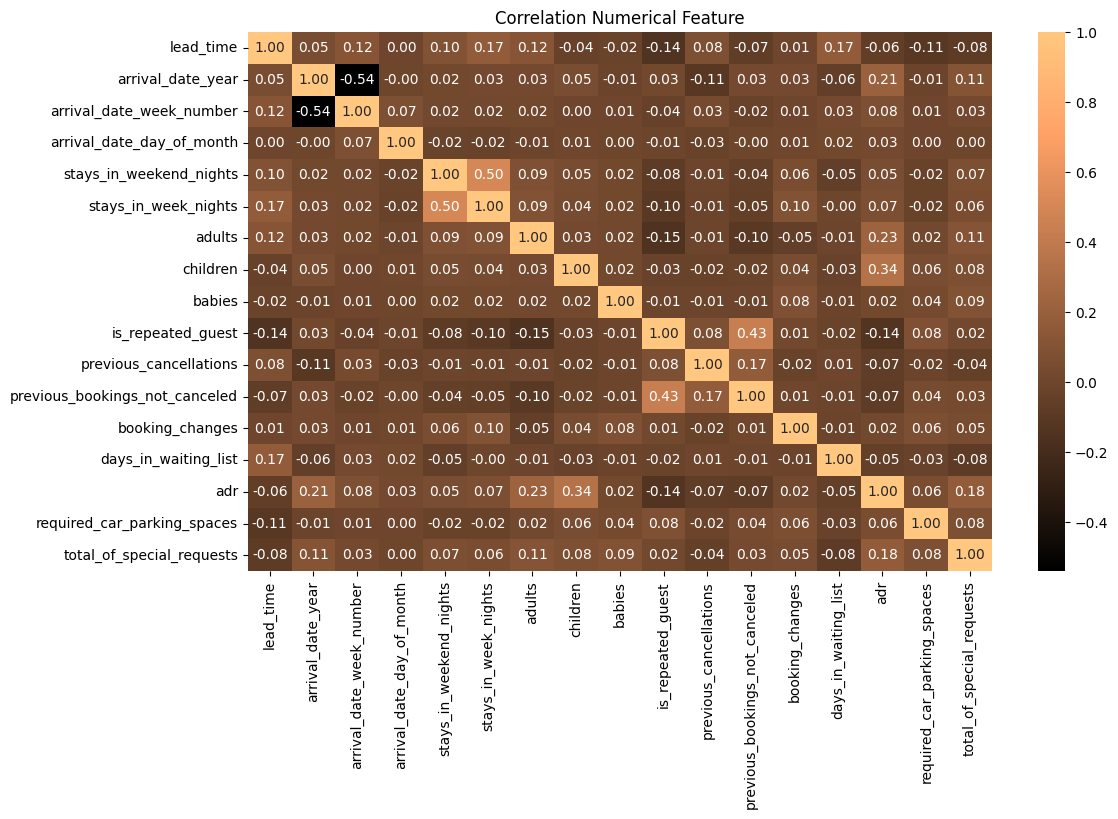

In [ ]:
plt.figure(figsize=(12,7))

sns.heatmap(hotel_real[numeric_real].corr(), cmap='copper', annot=True, fmt='.2f')

plt.title('Correlation Numerical Feature')
plt.show()

Feature independen satu sama lainnya.

### Deep Dive

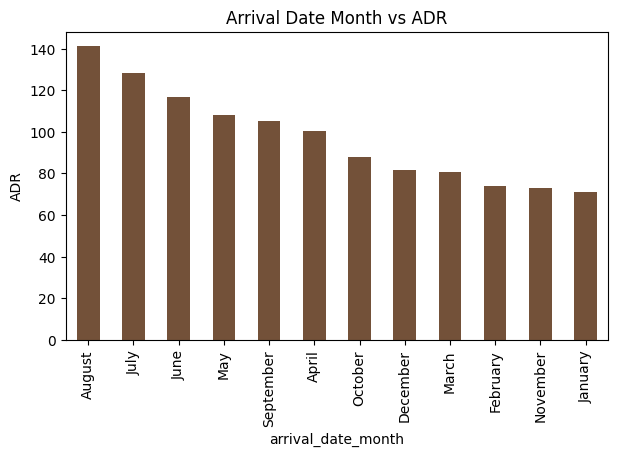

In [ ]:
combine_month = hotel_real.groupby('arrival_date_month')['adr'].mean()
combine_month = combine_month.sort_values(ascending=False)
combine_month.plot(kind='bar', color= '#735139', figsize=(7,4))
plt.ylabel('ADR')
plt.title('Arrival Date Month vs ADR')
plt.show()

Nilai ADR paling tinggi ada pada kedatangan penlanggan bulan Agustus, Juli dan Juni.

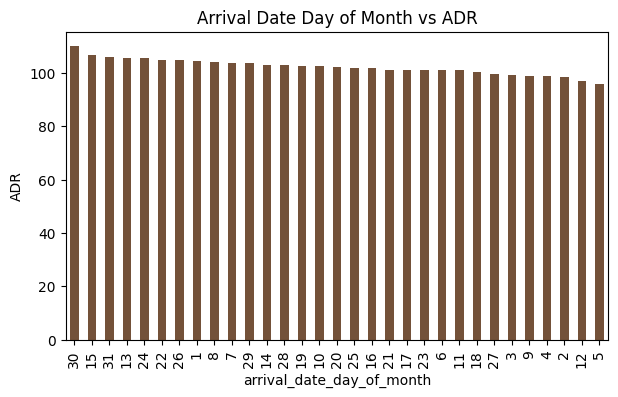

In [ ]:
combine_ddmm = hotel_real.groupby('arrival_date_day_of_month')['adr'].mean()
combine_ddmm = combine_ddmm.sort_values(ascending=False)
combine_ddmm.plot(kind='bar', color= '#735139', figsize=(7,4))
plt.ylabel('ADR')
plt.title('Arrival Date Day of Month vs ADR')
plt.show()

Nilai ADR paling tinggi ada pada kedatangan pelanggan di tanggal 30.

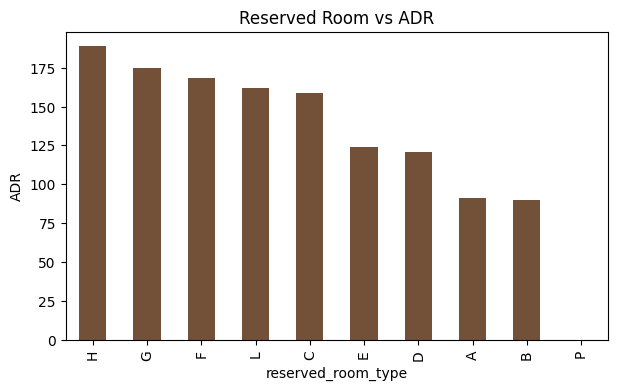

In [ ]:
combine_rroom = hotel_real.groupby('reserved_room_type')['adr'].mean()
combine_rroom = combine_rroom.sort_values(ascending=False)
combine_rroom.plot(kind='bar', color= '#735139', figsize=(7,4))
plt.ylabel('ADR')
plt.title('Reserved Room vs ADR')
plt.show()

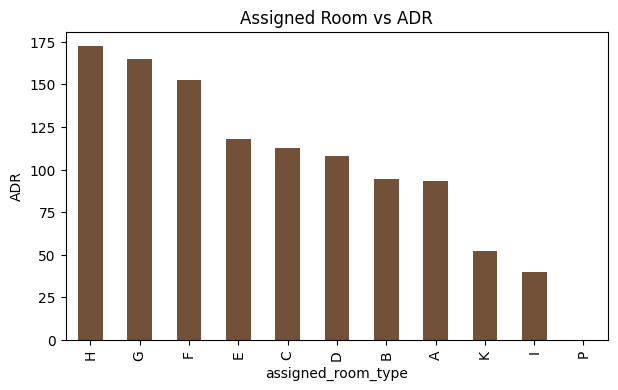

In [ ]:
combine_aroom = hotel_real.groupby('assigned_room_type')['adr'].mean()
combine_aroom = combine_aroom.sort_values(ascending=False)
combine_aroom.plot(kind='bar', color= '#735139', figsize=(7,4))
plt.ylabel('ADR')
plt.title('Assigned Room vs ADR')
plt.show()

Nilai ADR paling tinggi ada pada tipe kamar
H.

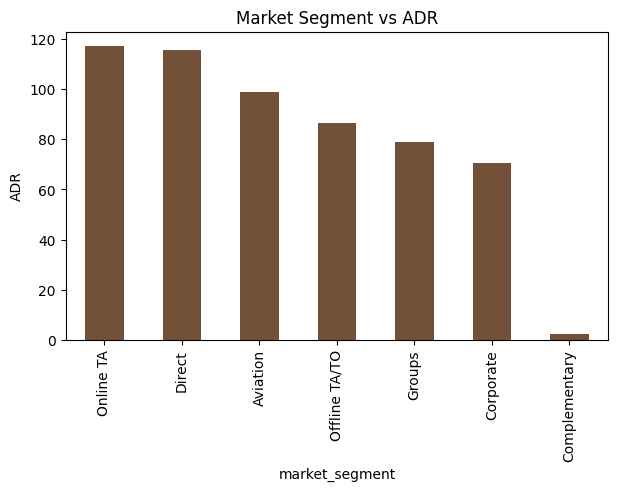

In [ ]:
combine_market = hotel_real.groupby('market_segment')['adr'].mean()
combine_market = combine_market.sort_values(ascending=False)
combine_market.plot(kind='bar', color= '#735139', figsize=(7,4))
plt.ylabel('ADR')
plt.title('Market Segment vs ADR')
plt.show()

Nilai ADR paling tinggi dilakukan pemesanan
kamar hotel menggunakan metode online TA dan direct.

## Feature Engineering

### Outliers Handling

In [ ]:
Q1 = hotel[numeric].quantile(0.25)
Q3 = hotel[numeric].quantile(0.75)

IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = (hotel[numeric]< lower) | (hotel[numeric] > upper)

outliers_hotel = outliers.sum(axis=0)
print(f'Jumlah baris outliers')
df = pd.DataFrame(outliers_hotel).reset_index()
df.columns = ['Column', 'Outliers']
df

Jumlah baris outliers


,Column,Outliers
0,lead_time,1970
1,arrival_date_year,0
2,arrival_date_week_number,0
3,arrival_date_day_of_month,0
4,stays_in_weekend_nights,191
5,stays_in_week_nights,2341
6,adults,20185
7,children,5951
8,babies,641
9,is_repeated_guest,2512


In [ ]:
hotel[numeric] = hotel[numeric].clip(lower=lower, upper=upper, axis=1)

In [ ]:
outliers = (hotel[numeric]< lower) | (hotel[numeric] > upper)

outliers_hotel = outliers.sum(axis=0)
print(f'Jumlah baris outliers')
df = pd.DataFrame(outliers_hotel).reset_index()
df.columns = ['Column', 'Outliers']
df

Jumlah baris outliers


,Column,Outliers
0,lead_time,0
1,arrival_date_year,0
2,arrival_date_week_number,0
3,arrival_date_day_of_month,0
4,stays_in_weekend_nights,0
5,stays_in_week_nights,0
6,adults,0
7,children,0
8,babies,0
9,is_repeated_guest,0


### Add New Feature

In [ ]:
hotel['customer'] = hotel['adults'] + hotel['children']

In [ ]:
hotel['lead_time'] = pd.cut(hotel['lead_time'], bins=[0, 100, 200, 300, float('inf')],#mengkelompokan data berdasarkan lama durasi
                                labels=['short', 'medium', 'long', 'very_long'], include_lowest=True)

In [ ]:
hotel['lead_time'] = hotel['lead_time'].map({'short' : 0, 'medium' : 1, 'long' : 2, 'very_long':3})

In [ ]:
hotel['lead_time'] = hotel['lead_time'].astype(int)

In [ ]:
hotel['source_hotel_booking'] = hotel['agent_available'] + hotel['company_available']

In [ ]:
def seasons(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Fall'
hotel['season'] = hotel['arrival_date_month'].apply(seasons)

In [ ]:
hotel['season'] = hotel['season'].map({'Winter' : 0, 'Spring' : 1, 'Summer' : 2, 'Fall':3})

In [ ]:
hotel['cancellation_rate'] = hotel['previous_cancellations'] / (hotel['previous_cancellations'] + hotel['previous_bookings_not_canceled'] + 1)

### Delete Feature Not Importance

In [ ]:
hotel = hotel.drop(['adults', 'children', 'babies', 'arrival_date_month', 'agent_available', 'company_available', 'previous_cancellations', 'previous_bookings_not_canceled'], axis=1)

In [ ]:
hotel.var()

,0
is_canceled,2.298031e-01
lead_time,8.163149e-01
arrival_date_year,4.980495e-01
arrival_date_week_number,1.850786e+02
arrival_date_day_of_month,7.716888e+01
stays_in_weekend_nights,9.467216e-01
stays_in_week_nights,2.381181e+00
meal,1.058726e+00
market_segment,1.940492e+00
distribution_channel,4.613456e-01


In [ ]:
hotel = hotel.loc[:, hotel.var() != 0]

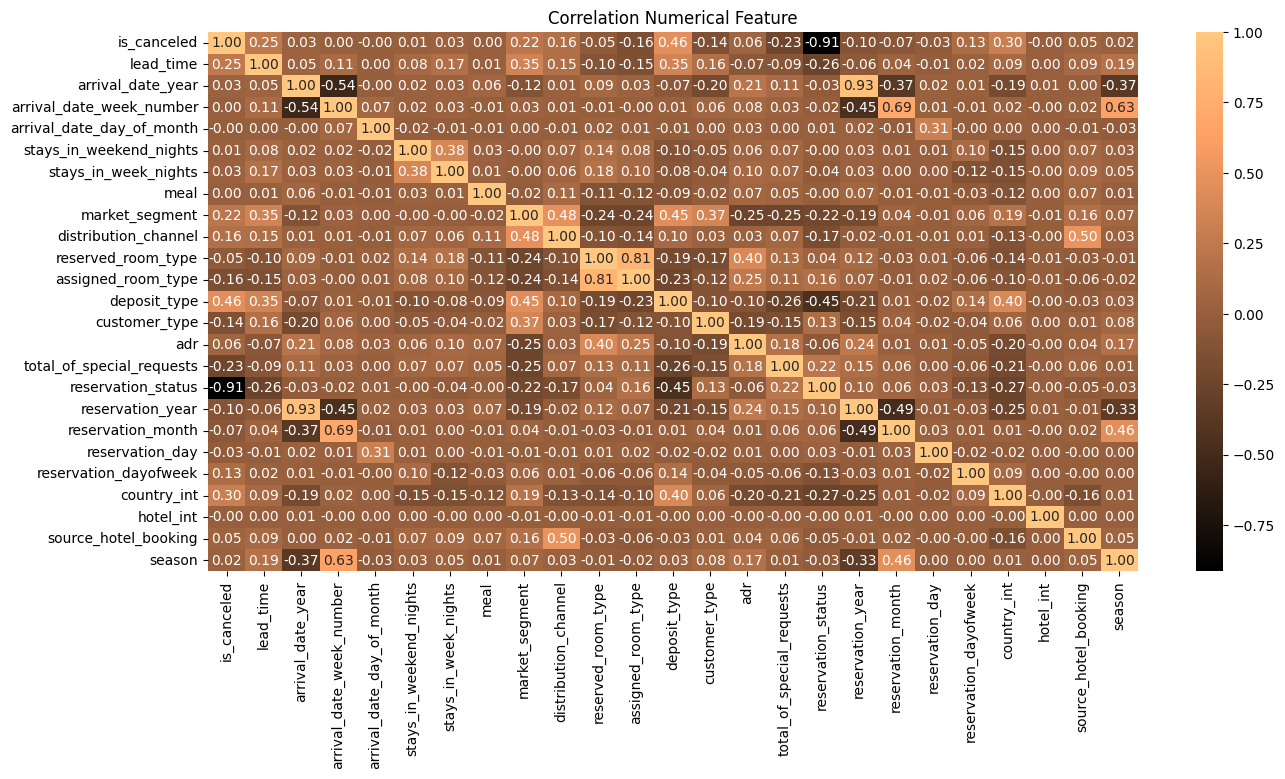

In [ ]:
plt.figure(figsize=(15,7))

sns.heatmap(hotel.corr(), cmap='copper', annot=True, fmt='.2f')

plt.title('Correlation Numerical Feature')
plt.show()

In [ ]:
hotel = hotel.drop(['reservation_month', 'reservation_day', 'hotel_int', 'reservation_dayofweek', 'distribution_channel', 'source_hotel_booking'], axis=1)

### Split Data

In [ ]:
X = hotel.drop('adr', axis=1) #Split data Train 80% dan test 20% dengan Fitur deposit menjadi target
y= hotel['adr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,market_segment,reserved_room_type,assigned_room_type,deposit_type,customer_type,total_of_special_requests,reservation_status,reservation_year,country_int,season
24802,0,2,2018,33,11,2,5,3,4,0,0,0,0,2.0,1,2018,8336,2
29830,0,0,2019,32,6,4,6,1,4,0,0,0,3,0.0,1,2019,7199,2
40225,1,0,2018,52,23,0,1,1,3,0,0,0,0,0.0,0,2018,31956,0
32394,0,0,2018,39,18,2,3,1,1,0,0,0,0,1.0,1,2018,31956,3
32143,0,0,2018,53,30,2,3,1,3,3,3,0,0,2.5,1,2019,162,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64469 entries, 24802 to 15964
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   is_canceled                64469 non-null  int64  
 1   lead_time                  64469 non-null  int64  
 2   arrival_date_year          64469 non-null  int64  
 3   arrival_date_week_number   64469 non-null  int64  
 4   arrival_date_day_of_month  64469 non-null  int64  
 5   stays_in_weekend_nights    64469 non-null  int64  
 6   stays_in_week_nights       64469 non-null  int64  
 7   meal                       64469 non-null  int64  
 8   market_segment             64469 non-null  int64  
 9   reserved_room_type         64469 non-null  int64  
 10  assigned_room_type         64469 non-null  int64  
 11  deposit_type               64469 non-null  int64  
 12  customer_type              64469 non-null  int64  
 13  total_of_special_requests  64469 non-null  floa

## Modeling

### Multikolinearitas

In [ ]:
X = add_constant(X_train) # mengecek nilai vif score per feature

vif_hotel = pd.DataFrame([vif(X.values, i)
                          for i in range(X.shape[1])],
                         index=X.columns).reset_index()
vif_hotel.columns = ['feature', 'vif_score']
vif_hotel = vif_hotel.loc[vif_hotel.feature != 'const']
vif_hotel

,feature,vif_score
1,is_canceled,6.152279
2,lead_time,1.456841
3,arrival_date_year,10.784577
4,arrival_date_week_number,2.178791
5,arrival_date_day_of_month,1.021152
6,stays_in_weekend_nights,1.208460
7,stays_in_week_nights,1.257595
8,meal,1.050179
9,market_segment,1.692284
10,reserved_room_type,3.259270


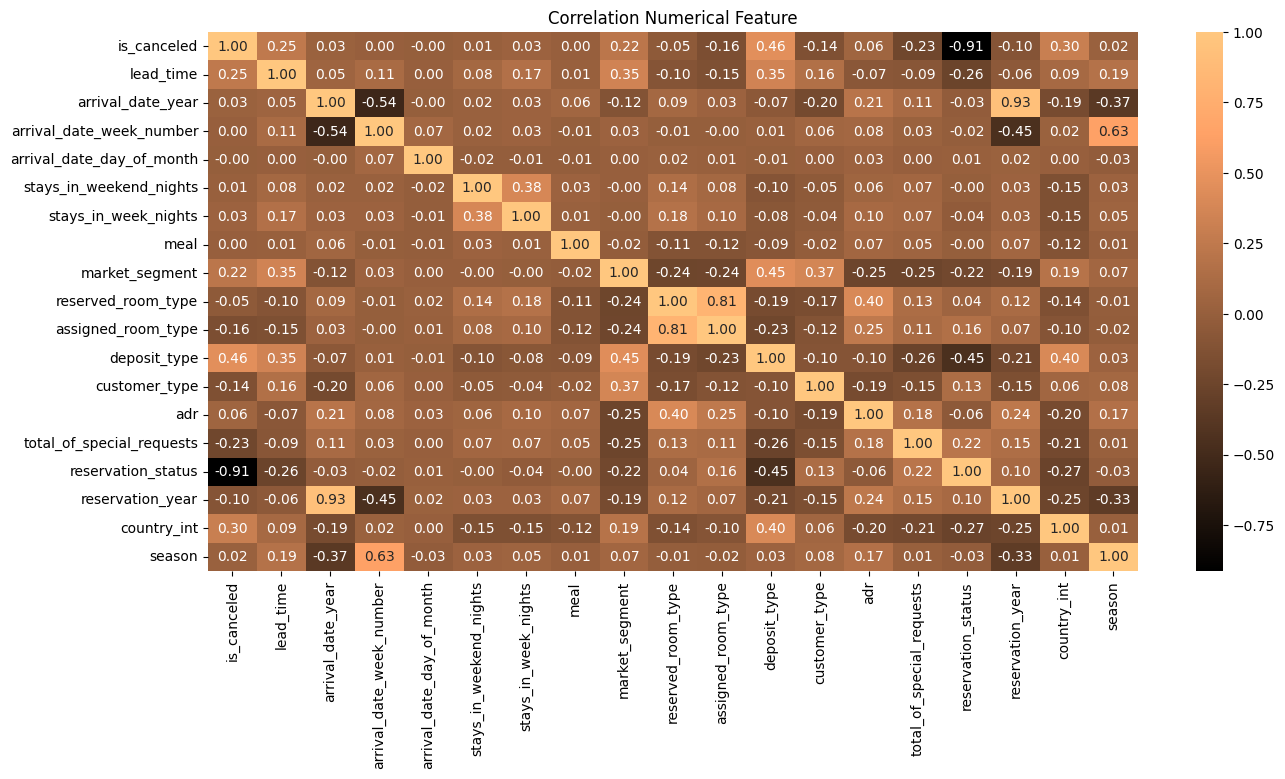

In [ ]:
plt.figure(figsize=(15,7))

sns.heatmap(hotel.corr(), cmap='copper', annot=True, fmt='.2f')

plt.title('Correlation Numerical Feature')
plt.show()

In [ ]:
X_train = X_train.drop(['arrival_date_year', 'reservation_year', 'is_canceled'], axis=1)
X_test = X_test.drop(['arrival_date_year', 'reservation_year', 'is_canceled'], axis=1)

In [ ]:
X = add_constant(X_train) # mengecek nilai vif score per feature

vif_hotel = pd.DataFrame([vif(X.values, i)
                          for i in range(X.shape[1])],
                         index=X.columns).reset_index()
vif_hotel.columns = ['feature', 'vif_score']
vif_hotel = vif_hotel.loc[vif_hotel.feature != 'const']
vif_hotel

,feature,vif_score
1,lead_time,1.351971
2,arrival_date_week_number,1.680499
3,arrival_date_day_of_month,1.015987
4,stays_in_weekend_nights,1.205855
5,stays_in_week_nights,1.256206
6,meal,1.047939
7,market_segment,1.687612
8,reserved_room_type,3.236794
9,assigned_room_type,3.157536
10,deposit_type,1.991212


### Baseline

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def create_pipeline(model, col):#membuat pipeline
  processor = ColumnTransformer(
      transformers=[('columns', StandardScaler(), col)]
  )
  pipeline = Pipeline(steps=[
      ('preprocessor', processor),
      ('regression', model)
  ])
  return pipeline

In [ ]:
def metric(X_train, y_train, X_test, y_test, col, kfold):
  models = {
      'Ridge': Ridge(random_state=42),
      'Lasso': Lasso(random_state=42),
      'Decision Tree': DecisionTreeRegressor(random_state=42),
      'XGBoost': XGBRegressor(random_state=42)
  }

  results =[]
  for name, model in models.items():
    pipeline = create_pipeline(model, col)


    scoring = {'R2': 'r2',
               'RMSE': 'neg_root_mean_squared_error',
               'MAE': 'neg_mean_absolute_error'}

    crossvalidation = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring)

    train_r2 = crossvalidation['test_R2'].mean()
    train_RMSE = -crossvalidation['test_RMSE'].mean()
    train_MAE = -crossvalidation['test_MAE'].mean()

    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_MAE = mean_absolute_error(y_test, y_test_pred)

    results.append({
        'Model' : name,
        'Train R2': train_r2,
        'Train RMSE': train_RMSE,
        'Train MAE': train_MAE,
        'Test R2': test_r2,
        'Test RMSE': test_RMSE,
        'Test MAE': test_MAE
    })

  result_metrics = pd.DataFrame(results)
  result_metrics = result_metrics.sort_values(by=['Train R2'], ascending=False)
  return result_metrics

In [ ]:
result_metrics= metric(X_train, y_train, X_test, y_test, X_train.columns, kf)
result_metrics

,Model,Train R2,Train RMSE,Train MAE,Test R2,Test RMSE,Test MAE
3,XGBoost,0.710208,24.124178,17.492518,0.707313,24.235745,17.506410
2,Decision Tree,0.505020,31.528949,18.678460,0.524106,30.903669,17.873403
0,Ridge,0.285153,37.891370,29.262208,0.277875,38.068107,29.474309
1,Lasso,0.272594,38.223124,29.567096,0.264304,38.424132,29.802889


### Hyperparameter Tuning

In [ ]:
def tuning_ridge(trial):
      params = {
                'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
                'max_iter': trial.suggest_int('max_iter', 100, 10000)
    }
      model = Ridge(**params, random_state=42)
      pipeline = create_pipeline(model, X_train.columns)

      r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
      r2 = r2.mean()

      return r2

study_ridge = optuna.create_study(direction='maximize')
study_ridge.optimize(tuning_ridge, n_trials=10)
best_param_ridge = study_ridge.best_params

print('Best Hyperparameters:', best_param_ridge)
print('Best R2:',study_ridge.best_value)

[I 2025-01-28 13:59:08,043] A new study created in memory with name: no-name-a26b3e54-ea91-4403-9529-24533fe26f6d
[I 2025-01-28 13:59:08,285] Trial 0 finished with value: 0.2851534884989067 and parameters: {'alpha': 2.047161862672258, 'max_iter': 3521}. Best is trial 0 with value: 0.2851534884989067.
[I 2025-01-28 13:59:08,618] Trial 1 finished with value: 0.28515346258436625 and parameters: {'alpha': 0.31371283165456715, 'max_iter': 343}. Best is trial 0 with value: 0.2851534884989067.
[I 2025-01-28 13:59:09,156] Trial 2 finished with value: 0.285153521959025 and parameters: {'alpha': 4.667523538347106, 'max_iter': 9782}. Best is trial 2 with value: 0.285153521959025.
[I 2025-01-28 13:59:09,653] Trial 3 finished with value: 0.28515345846956863 and parameters: {'alpha': 0.05569809357835553, 'max_iter': 5142}. Best is trial 2 with value: 0.285153521959025.
[I 2025-01-28 13:59:10,177] Trial 4 finished with value: 0.2851534615968955 and parameters: {'alpha': 0.2514109845805475, 'max_iter'

Best Hyperparameters: {'alpha': 4.667523538347106, 'max_iter': 9782}
Best R2: 0.285153521959025


In [ ]:
def tuning_lasso(trial):
      params = {
                'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
                'max_iter': trial.suggest_int('max_iter', 100, 10000)
    }
      model = Lasso(**params, random_state=42)
      pipeline = create_pipeline(model, X_train.columns)

      r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
      r2 = r2.mean()

      return r2

study_lasso = optuna.create_study(direction='maximize')
study_lasso.optimize(tuning_lasso, n_trials=10)
best_param_lasso = study_lasso.best_params

print('Best Hyperparameters:', best_param_lasso)
print('Best R2:',study_lasso.best_value)

[I 2025-01-28 13:59:12,557] A new study created in memory with name: no-name-d734c974-3dd7-4f75-826a-d237b3418304
[I 2025-01-28 13:59:13,280] Trial 0 finished with value: 0.2842939527551377 and parameters: {'alpha': 0.24148879286087738, 'max_iter': 2779}. Best is trial 0 with value: 0.2842939527551377.
[I 2025-01-28 13:59:14,069] Trial 1 finished with value: 0.2620496839501004 and parameters: {'alpha': 1.4727296159936214, 'max_iter': 9440}. Best is trial 0 with value: 0.2842939527551377.
[I 2025-01-28 13:59:14,466] Trial 2 finished with value: 0.13367755345130647 and parameters: {'alpha': 7.996797211815897, 'max_iter': 5045}. Best is trial 0 with value: 0.2842939527551377.
[I 2025-01-28 13:59:14,882] Trial 3 finished with value: 0.2419582830205344 and parameters: {'alpha': 2.824784186620276, 'max_iter': 2823}. Best is trial 0 with value: 0.2842939527551377.
[I 2025-01-28 13:59:15,414] Trial 4 finished with value: 0.25711654893038105 and parameters: {'alpha': 1.8931227576582141, 'max_it

Best Hyperparameters: {'alpha': 0.013497628319125647, 'max_iter': 3100}
Best R2: 0.28515101615435023


In [ ]:
def tuning_dt(trial):
      params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 3, 10),
    }
      model = DecisionTreeRegressor(**params, random_state=42)
      pipeline = create_pipeline(model, X_train.columns)

      r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
      r2 = r2.mean()

      return r2

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(tuning_dt, n_trials=10)
best_param_dt = study_dt.best_params

print('Best Hyperparameters:', best_param_dt)
print('Best R2:',study_dt.best_value)

[I 2025-01-28 13:59:17,901] A new study created in memory with name: no-name-cfdba1a0-07f5-4032-b851-80cccd0ef989
[I 2025-01-28 13:59:18,467] Trial 0 finished with value: 0.43781996344916774 and parameters: {'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.43781996344916774.
[I 2025-01-28 13:59:18,853] Trial 1 finished with value: 0.30974410817763 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.43781996344916774.
[I 2025-01-28 13:59:19,673] Trial 2 finished with value: 0.586705512467681 and parameters: {'max_depth': 10, 'min_samples_split': 8}. Best is trial 2 with value: 0.586705512467681.
[I 2025-01-28 13:59:20,125] Trial 3 finished with value: 0.3964250667628937 and parameters: {'max_depth': 4, 'min_samples_split': 10}. Best is trial 2 with value: 0.586705512467681.
[I 2025-01-28 13:59:20,928] Trial 4 finished with value: 0.5863520858279554 and parameters: {'max_depth': 10, 'min_samples_split': 10}. Best is trial 2 with v

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 8}
Best R2: 0.586705512467681


In [ ]:
def tuning_xgb(trial):
      params = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 200),
      'max_depth': trial.suggest_int('max_depth', 3, 10)
    }
      model = XGBRegressor(**params, random_state=42)
      pipeline = create_pipeline(model, X_train.columns)

      r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
      r2 = r2.mean()

      return r2

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(tuning_xgb, n_trials=10)
best_param_xgb = study_xgb.best_params

print('Best Hyperparameters:', best_param_xgb)
print('Best R2:',study_xgb.best_value)

[I 2025-01-28 13:59:24,623] A new study created in memory with name: no-name-3b5595c9-79f5-44de-bd4c-11b72c49f2cc
[I 2025-01-28 13:59:29,246] Trial 0 finished with value: 0.6791271488704466 and parameters: {'n_estimators': 164, 'max_depth': 4}. Best is trial 0 with value: 0.6791271488704466.
[I 2025-01-28 13:59:30,851] Trial 1 finished with value: 0.6347953788969317 and parameters: {'n_estimators': 104, 'max_depth': 3}. Best is trial 0 with value: 0.6791271488704466.
[I 2025-01-28 13:59:33,954] Trial 2 finished with value: 0.727158445225775 and parameters: {'n_estimators': 113, 'max_depth': 7}. Best is trial 2 with value: 0.727158445225775.
[I 2025-01-28 13:59:42,808] Trial 3 finished with value: 0.7345392499969599 and parameters: {'n_estimators': 133, 'max_depth': 9}. Best is trial 3 with value: 0.7345392499969599.
[I 2025-01-28 13:59:43,875] Trial 4 finished with value: 0.6109785252557092 and parameters: {'n_estimators': 52, 'max_depth': 3}. Best is trial 3 with value: 0.734539249996

Best Hyperparameters: {'n_estimators': 133, 'max_depth': 9}
Best R2: 0.7345392499969599


In [ ]:
best_params = {
      'Ridge': best_param_ridge,
      'Lasso': best_param_lasso,
      'Decision Tree': best_param_dt,
      'XGBoost': best_param_xgb
}
best_params

{'Ridge': {'alpha': 4.667523538347106, 'max_iter': 9782},
 'Lasso': {'alpha': 0.013497628319125647, 'max_iter': 3100},
 'Decision Tree': {'max_depth': 10, 'min_samples_split': 8},
 'XGBoost': {'n_estimators': 133, 'max_depth': 9}}

### Train vs Test

In [ ]:
def model_best_param(X_train, y_train, X_test, y_test, col, kfold):
  models = {
      'Ridge': Ridge(random_state=42),
      'Lasso': Lasso(random_state=42),
      'Decision Tree': DecisionTreeRegressor(random_state=42),
      'XGBoost': XGBRegressor(random_state=42)
  }

  results =[]
  for name, permodel in models.items():
    model = permodel.set_params(**best_params[name])
    pipeline = create_pipeline(model, col)


    scoring = {'R2': 'r2',
               'RMSE': 'neg_root_mean_squared_error',
               'MAE': 'neg_mean_absolute_error'}

    crossvalidation = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring)

    train_r2 = crossvalidation['test_R2'].mean()
    train_RMSE = -crossvalidation['test_RMSE'].mean()
    train_MAE = -crossvalidation['test_MAE'].mean()

    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_MAE = mean_absolute_error(y_test, y_test_pred)

    results.append({
        'Model' : name,
        'Train R2': train_r2,
        'Train RMSE': train_RMSE,
        'Train MAE': train_MAE,
        'Test R2': test_r2,
        'Test RMSE': test_RMSE,
        'Test MAE': test_MAE
    })

  results_tuning = pd.DataFrame(results)
  results_tuning = results_tuning.sort_values(by=['Train R2'], ascending=False)
  return results_tuning

In [ ]:
results_tuning = model_best_param(X_train, y_train, X_test, y_test, X_train.columns, kf)
results_tuning

,Model,Train R2,Train RMSE,Train MAE,Test R2,Test RMSE,Test MAE
3,XGBoost,0.734539,23.088351,15.552601,0.750057,22.396279,15.121029
2,Decision Tree,0.586706,28.811238,20.858586,0.588140,28.749472,20.902171
0,Ridge,0.285154,37.891369,29.262252,0.277874,38.068116,29.474365
1,Lasso,0.285151,37.891441,29.262022,0.277857,38.068584,29.474813


Dari keempat model yang sudah di hypertuning parameter didapatkan hasil bahwa XgboostRegessor unggul dibandingkan model lainnya pada metrics R2, RMSE dan MAE.

### Feature Importance

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train )
X_test_std = scaler.transform(X_test)

In [ ]:
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)

In [ ]:
modelXGB = XGBRegressor(**best_param_xgb, random_state=42).fit(X_train_std, y_train)
y_test_predxgb = modelXGB.predict(X_test_std)

In [ ]:
XGB_exp = dx.Explainer(modelXGB, X_train_std, y_train, label='XGBOOST Interpretation')

Preparation of a new explainer is initiated

  -> data              : 64469 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 64469 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBOOST Interpretation
  -> predict function  : <function yhat_default at 0x7cd37d9b9120> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -18.8, mean = 1.01e+02, max = 2.29e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.68e+02, mean = 0.000505, max = 1.13e+02
  -> model_info        : package xgboost

A new explainer has been created!


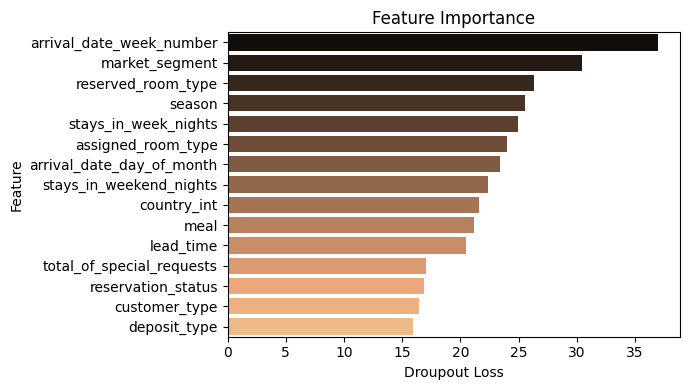

In [ ]:
modelparts = XGB_exp.model_parts()

parts = modelparts.result.sort_values(by='dropout_loss', ascending=False)
parts_feature = parts[(parts['variable'] != '_baseline_') & (parts['variable'] != '_full_model_')]

plt.figure(figsize=(7,4))
sns.barplot(x='dropout_loss', y='variable', hue='variable', data=parts_feature, palette='copper')
plt.xlabel('Droupout Loss')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()

Feature yang paling memiliki peran penting dalam modeling adalah arrival_date_week_number, market_segment dan reserver_room_type.

## Recomendation

1. Optimalkan harga sewa kamar pada bulan Juni, Juli dan Agustus.
  - Peningkatan ADR pada bulan tersebut, hotel dapat menaikan harga saat permintaan tinggi.
  - Buat promo early booking untuk menarik tamu agar memesan jauh-jauh hari dengan harga yang lebih kompetitif.<br>
2. Maksimalkan pemesanan untuk tanggal 30.
  - Peningkatan ADR pada tanggal 30, hotel dapat mempertimbangkan untuk meningkatkan harga di tanggal tersebut dengan ditambahkan promo tambahan (seperti breakfast, spa atau free shuttle bus)<br>
3. Tingkatkan penjualan tipe kamar H.
  - Fokuskan promosi pada tipe kamar H
  - Gunakan strategi marketing yag menarik untuk meningkatkan daya tarik tipe kamar ini (seperti, menggunakan foto dan deskripsi menarik pada market segmen online)<br>
4. Perkuat pemesanan melalui Online Travel Agent (OTA) dan direct booking.
  - Optimalkan penjualan di berbagai OTA dengan foto, deskripsi menarik dan ulasan positif.
  - Dorong pemesanan langsung (direct booking) melalui website hotel dengan menawarkan diskon eksklusif atau fasilitas tambahan bagi pelanggan yang memsan kamar secara langsung.